# Camera Calibration Using Moon Observations

This notebook implements camera calibration using video observations of the moon from a fixed camera position.
The approach follows these key steps:
1. Video preprocessing to extract clear moon frames
2. Moon detection using circular Hough transform
3. Sub-pixel accuracy with ellipse fitting
4. Astronomical calculations for expected moon positions
5. Least squares optimization for parameter refinement

In [6]:
# Enable interactive matplotlib backend
# %matplotlib widget

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body, ITRS
from astropy import units as u
import pandas as pd
from datetime import datetime
import os

#

In [7]:
#  I have GPS coosrdinate that needs to considred as origin
origin_lat = 43.07063697146  # Example: New York City latitude
origin_lon = -89.40685704184578  # Example: New York City longitude
origin_alt = 263 + 204*0.3048
from pyproj import Proj, transform


def get_moon_ecef(time):
    # Get Moon position in ICRS frame
    moon_icrs = get_body('moon', time)
    
    # Convert to ITRS (Earth-fixed frame, essentially ECEF)
    moon_itrs = moon_icrs.transform_to(ITRS(obstime=time))
    
    # Extract ECEF coordinates
    x = moon_itrs.x.to(u.m).value
    y = moon_itrs.y.to(u.m).value  
    z = moon_itrs.z.to(u.m).value
    
    return np.array([x, y, z])

In [8]:
from astropy.time import TimeDelta

date = "2025-08-11"

# read images from images/south directory
image_dir = "/Users/shrenikborad/Downloads/NNDL/images/south/moon_images"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
# file name is 00_58_58.trig+00.jpg for 2025-08-11. So extract time 00_58_58 hh:mm:ss from file name
image_timestamps = [f.split('.')[0].replace('.jpg', '') for f in image_files]
image_timestamp_clean = [f"{ts[:2]}:{ts[3:5]}:{ts[6:]}" for ts in image_timestamps] 
image_datetimes = [f"{date} {ts}" for ts in image_timestamp_clean]
# Convert datetimes from CDT (UTC-5) to UTC for astropy Time
# CDT is UTC-5, so add 5 hours to convert to UTC
image_times = Time(image_datetimes) + TimeDelta(5 * 3600, format='sec')
image_times.format = 'iso'
image_times

<Time object: scale='utc' format='iso' value=['2025-08-11 05:58:58.000' '2025-08-11 06:35:48.000'
 '2025-08-11 06:51:38.000' '2025-08-11 07:40:28.000'
 '2025-08-11 07:46:58.000' '2025-08-11 08:26:18.000'
 '2025-08-11 09:13:08.000']>

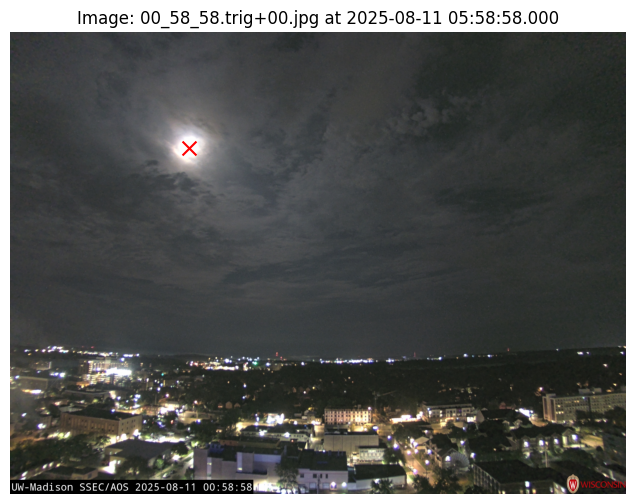

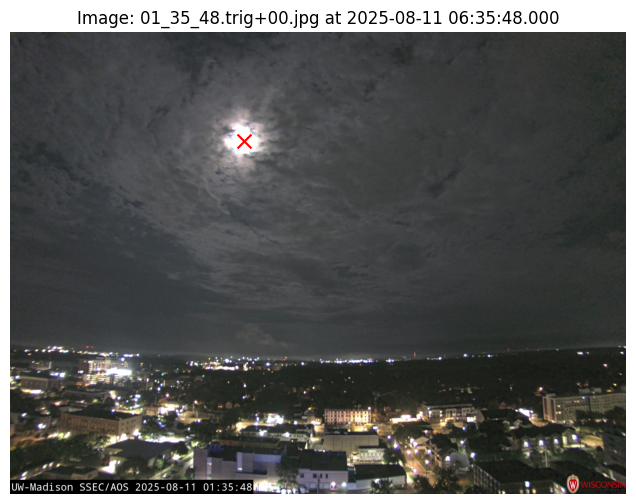

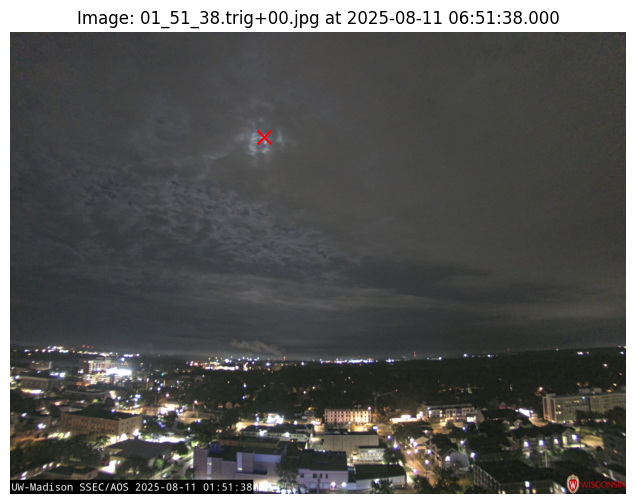

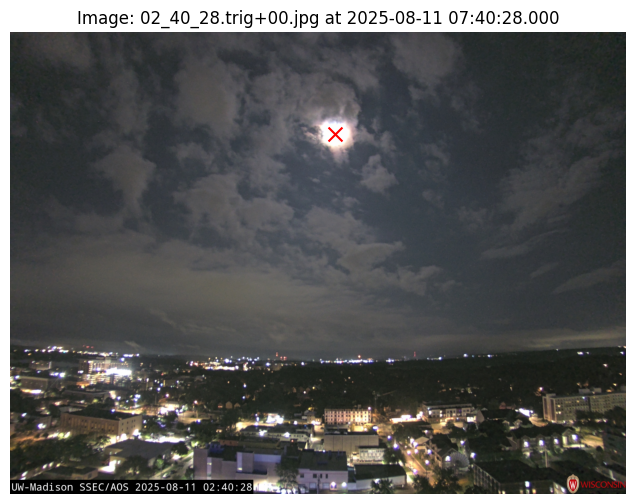

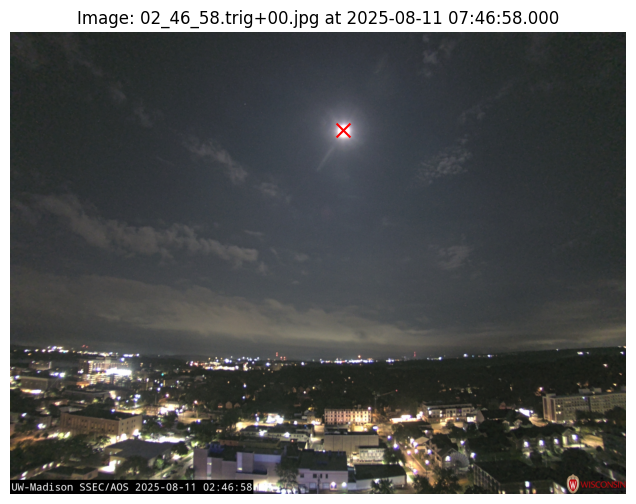

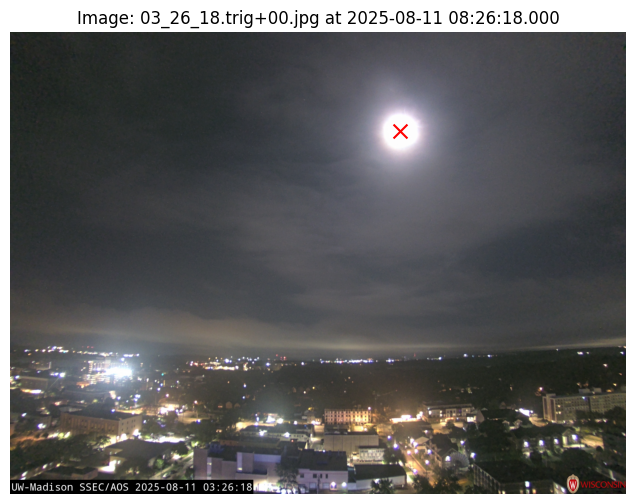

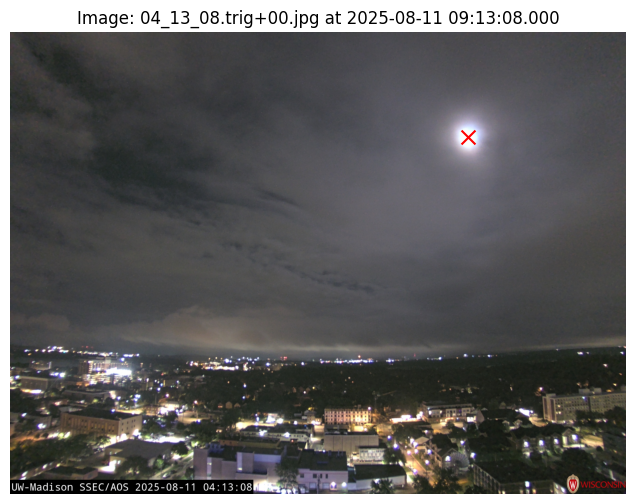

In [9]:
moon_pixels = list(reversed([[1927, 443], [1642,416], [1402,412], [1368,430], [1070,440],[984,460], [751,488]]))
# timestamps = ["04_13_08.trig+00", "03_26_18.trig+00", "02_46_58.trig+00", "02_40_28.trig+00", "01_51_38.trig+00", "01_35_48.trig+00", "00_58_58.trig+00"]

# show images with moon pixels marked
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    # Fix: .reverse() returns None, so assign reversed list to moon_pixels
    plt.scatter(moon_pixels[i][0], moon_pixels[i][1], c='red', s=100, marker='x')
    plt.title(f"Image: {img_file} at {image_times[i].iso}")
    plt.axis('off')
    plt.show()

In [10]:
moon_ecefs = np.array([get_moon_ecef(t) for t in image_times])

In [11]:
moon_ecefs

array([[ 1.57438348e+08, -3.35796679e+08, -4.54453875e+07],
       [ 1.03515917e+08, -3.56199750e+08, -4.43586036e+07],
       [ 7.94831128e+07, -3.62348078e+08, -4.38909235e+07],
       [ 3.57762173e+06, -3.71025749e+08, -4.24466096e+07],
       [-6.61066953e+06, -3.70994397e+08, -4.22541513e+07],
       [-6.78933839e+07, -3.64850685e+08, -4.10884948e+07],
       [-1.38310323e+08, -3.44451146e+08, -3.96983043e+07]])

In [12]:
from pyproj import Transformer, CRS
import numpy as np
import cv2
import pymap3d as pm


def ecef_to_enu(origin_ecef, points_ecef):

    # use pymap3d to convert ecef to enu
    enu_points = pm.ecef2enu(points_ecef[:, 0], points_ecef[:, 1], points_ecef[:, 2],
                              origin_ecef[0], origin_ecef[1], origin_ecef[2])
    # make numpy array
    return np.array(enu_points).T


def gps_to_camxy_vasha_fixed(lats, lons, alts, cam_ecef, cam_k, cam_r, cam_t, camera_gps, distortion=None):
    """
    Fixed version of GPS to camera coordinates conversion.
    Properly handles objects behind camera and outside frame.
    """
    # Convert GPS to ECEF
    transformer_geodetic_to_ecef = Transformer.from_crs(
        "epsg:4979", "epsg:4978", always_xy=True)
    eX, eY, eZ = transformer_geodetic_to_ecef.transform(lons, lats, alts)
    ecef_points = np.column_stack((eX, eY, eZ))

    # Convert ECEF to ENU relative to camera
    enu_points = ecef_to_enu(
        camera_gps, ecef_points)  # Shape: (N, 3)

    # CRITICAL FIX 1: Transform to camera coordinate system properly
    # Camera coordinates: X=right, Y=down, Z=forward (into scene)
    points_cam = (cam_r @ enu_points.T + cam_t).T  # Shape: (N, 3)

    # CRITICAL FIX 2: Filter out points behind camera BEFORE projection
    # Points with negative Z are behind the camera
    behind_camera_mask = points_cam[:, 2] <= 0

    # Initialize output arrays
    num_points = len(lats)
    image_x = np.full(num_points, np.nan)
    image_y = np.full(num_points, np.nan)
    cam_distance = points_cam[:, 2]  # Z coordinate is the distance

    # Only project points in front of camera
    if np.any(~behind_camera_mask):
        valid_points = enu_points[~behind_camera_mask]

        # Project using OpenCV
        rvec, _ = cv2.Rodrigues(cam_r)
        tvec = cam_t.astype(np.float32)

        if distortion is None:
            distortion = np.zeros((5, 1), dtype=np.float32)

        image_points, _ = cv2.projectPoints(
            valid_points.astype(np.float32),
            rvec, tvec, cam_k, distortion
        )
        image_points = image_points.reshape(-1, 2)

        # Assign projected coordinates back to output arrays
        valid_indices = np.where(~behind_camera_mask)[0]
        image_x[valid_indices] = image_points[:, 0]
        image_y[valid_indices] = image_points[:, 1]

    return image_x, image_y, cam_distance

def gps_to_ecef(points_gps):
    transformer_geodetic_to_ecef = Transformer.from_crs(
        "epsg:4979", "epsg:4978", always_xy=True)
    eX, eY, eZ = transformer_geodetic_to_ecef.transform(
        points_gps[:, 1], points_gps[:, 0], points_gps[:, 2])
    ecef_points = np.vstack((eX, eY, eZ)).T  # Shape: (N, 3)
    return ecef_points

def estimate_camera_params(origin_gps, poi_ecef, poi_xy, frame_size, intrinsics_estimate=None, distortion_estimate=None, rvecs=None, tvecs=None):
    # Convert camera GPS coordinates to ECEF
    transformer_geodetic_to_ecef = Transformer.from_crs(
        "epsg:4979", "epsg:4978", always_xy=True)
    # Note: pyproj expects lon,lat,alt order
    eX, eY, eZ = transformer_geodetic_to_ecef.transform(
        origin_gps[1], origin_gps[0], origin_gps[2])
    cam_ecef = np.array([eX, eY, eZ]).T  # /1000  # Shape: (3,)
    # eX, eY, eZ = transformer_geodetic_to_ecef.transform(
    #     poi_gps[:, 1], poi_gps[:, 0], poi_gps[:, 2])
    # poi_ecef = np.vstack((eX, eY, eZ)).T  # /1000  # Shape: (3, N)
    poi_enu = ecef_to_enu(
        origin_gps, poi_ecef)  # Shape: (N,3)

    # Put everything in contiguous arrays with (N, 3), not (3, N)
    object_points = np.ascontiguousarray(poi_enu.astype(np.float32))  # (N, 3)
    image_points = np.ascontiguousarray(
        poi_xy.astype(np.float32))      # (N, 2)

    if intrinsics_estimate is None:
        estimated_focal_dist = 1e5
        intrinsics_estimate = np.array([[estimated_focal_dist, 0, frame_size[1] / 2],
                                        [0, estimated_focal_dist,
                                            frame_size[0] / 2],
                                        [0, 0, 1]], dtype=np.float32)  # (3, 3)
    if distortion_estimate is None:
        # Use a zero distortion model if not provided
        distortion_estimate = np.zeros((5, 1), dtype=np.float32)

    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        10000,    # Maximum 10,000 iterations (vs default ~30)
        1e-12     # Extremely tight convergence (vs default 1e-6)
    )
    print("Initial intrinsics:\n", intrinsics_estimate)
    print("Initial distortion:\n", distortion_estimate.ravel())
    calibrate_flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |         # Use your good initial guess
        # cv2.CALIB_USE_LU |                    # Use your good initial guess
        cv2.CALIB_FIX_PRINCIPAL_POINT  |        # Keep principal point fixed
        # cv2.CALIB_FIX_FOCAL_LENGTH |          # Keep focal lengths fixed
        cv2.CALIB_FIX_ASPECT_RATIO |            # Keep fx/fy ratio fixed
        # cv2.CALIB_FIX_K1 |
        # cv2.CALIB_FIX_K2 | 
        # cv2.CALIB_FIX_K3 |      # keep all c
        # cv2.CALIB_FIX_P1 | 
        # CALIB_FIX_P2 |  #fix tangential distortion
        # fix higher order radial distortions
        cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6 |
        cv2.CALIB_ZERO_TANGENT_DIST           # Only estimate radial distortion
        | cv2.CALIB_USE_EXTRINSIC_GUESS
    )
    # Let OpenCV estimate all distortion parameters
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        [object_points], [image_points], frame_size,
        intrinsics_estimate,
        distortion_estimate,
        rvecs,
        tvecs,
        flags=calibrate_flags,
        criteria=criteria
    )

    T = tvecs[0]  # .reshape(3, 1)  # Reshape to (3, 1)
    R, _ = cv2.Rodrigues(rvecs[0])

    return camera_matrix, dist_coeffs, R, T, cam_ecef


def calculate_fov_from_intrinsics(intrinsics, image_width, image_height, distortion=None):
    """
    Calculate horizontal and vertical field of view from camera intrinsics matrix.

    *** NOTE: This method assumes no distortion is applied.
    Without distortion -  ***

    Args:
        intrinsics: 3x3 camera intrinsics matrix (K matrix)
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels
        distortion: Optional distortion coefficients (not used in this calculation)

    Returns:
        hfov: Horizontal field of view in radians
        vfov: Vertical field of view in radians
        hfov_deg: Horizontal field of view in degrees
        vfov_deg: Vertical field of view in degrees
    """
    # Extract focal lengths and principal point
    fx = intrinsics[0, 0]  # focal length in x (pixels)
    fy = intrinsics[1, 1]  # focal length in y (pixels)
    cx = intrinsics[0, 2]  # principal point x
    cy = intrinsics[1, 2]  # principal point y

    # Left and right angles from principal point
    angle_left = np.arctan(cx / fx)
    angle_right = np.arctan((image_width - cx) / fx)
    hfov = angle_left + angle_right

    # Top and bottom angles from principal point
    angle_top = np.arctan(cy / fy)
    angle_bottom = np.arctan((image_height - cy) / fy)
    vfov = angle_top + angle_bottom

    # Method 2: Simplified calculation (assumes centered principal point)
    # hfov_simple = 2 * np.arctan(image_width / (2 * fx))
    # vfov_simple = 2 * np.arctan(image_height / (2 * fy))

    # Convert to degrees for display
    hfov_deg = np.degrees(hfov)
    vfov_deg = np.degrees(vfov)

    # return hfov, vfov, hfov_deg, vfov_deg
    return (hfov_deg.item(), vfov_deg.item())

In [14]:
from PIL import Image

focal_length_deg = 63.59  # Example: 60 degrees
default_img = Image.open("/Users/shrenikborad/Downloads/NNDL/images/south/DEFAULT.jpg")
frame_size = (default_img.height, default_img.width)
focal_length = 0.5 * frame_size[0] / \
            np.tan(0.5 * np.radians(focal_length_deg))

# Create initial K matrix (intrinsics)
initial_k = np.array([
    [focal_length, 0, frame_size[1] / 2],
    [0, focal_length, frame_size[0] / 2],
    [0, 0, 1]
], dtype=np.float32)

In [15]:
# read csv file
poi_data = pd.read_csv("/Users/shrenikborad/Downloads/NNDL/images/south/matches.csv")
poi_data.head()

id  img_x  img_y    map_lat    map_lng  map_altitude
0   1   1889   1856  43.068986 -89.407610    261.783813
1   2   2246   1636  43.068112 -89.409184    261.314819
2   3   1793   1654  43.067675 -89.407977    259.928284
3   4    398   1808  43.068984 -89.405066    260.524017
4   5   1286   1678  43.067821 -89.406539    259.167053

In [16]:
poi_xy = poi_data[['img_x', 'img_y']].to_numpy()
poi_xy
poi_gps = poi_data[['map_lat', 'map_lng', 'map_altitude']].to_numpy()
poi_gps
poi_ecef = gps_to_ecef(poi_gps)
poi_ecef

array([[   48251.07541434, -4666664.99040011,  4333282.37889827],
       [   48123.61102217, -4666732.27437099,  4333211.12352683],
       [   48222.207976  , -4666763.35611569,  4333174.75404006],
       [   48458.31935462, -4666662.04086904,  4333281.39212082],
       [   48339.19515405, -4666750.53674719,  4333186.05832767],
       [   48359.19282773, -4666794.25153073,  4333139.73977874]])

In [17]:
# merge moon_ecefs and poi_ecef
all_poi_ecef = np.vstack(( poi_ecef))
all_poi_xy = np.vstack(( poi_xy))
print(all_poi_ecef)
print(all_poi_xy)

[[   48251.07541434 -4666664.99040011  4333282.37889827]
 [   48123.61102217 -4666732.27437099  4333211.12352683]
 [   48222.207976   -4666763.35611569  4333174.75404006]
 [   48458.31935462 -4666662.04086904  4333281.39212082]
 [   48339.19515405 -4666750.53674719  4333186.05832767]
 [   48359.19282773 -4666794.25153073  4333139.73977874]]
[[1889 1856]
 [2246 1636]
 [1793 1654]
 [ 398 1808]
 [1286 1678]
 [1224 1619]]


In [18]:
k_matrix, dist_coeffs, r_matrix, t_vector, cam_ecef_coords = estimate_camera_params(origin_gps=(origin_lat, origin_lon, origin_alt),
                       poi_ecef=all_poi_ecef,
                       poi_xy=all_poi_xy,
                       frame_size=frame_size,
                       intrinsics_estimate=initial_k,
                       distortion_estimate=None)


Initial intrinsics:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion:
 [0. 0. 0. 0. 0.]


In [20]:
import json
camera_params = {
    "intrinsics": k_matrix.tolist(),
    "distortion": dist_coeffs.ravel().tolist(),
    "rotation": r_matrix.tolist(),
    "translation": t_vector.ravel().tolist(),
    "origin_gps": {
        "lat": origin_lat,
        "lon": origin_lon,
        "alt": origin_alt
    }}
with open("/Users/shrenikborad/Downloads/NNDL/images/south/camera_params.json", "w") as f:
    json.dump(camera_params, f, indent=4)
    

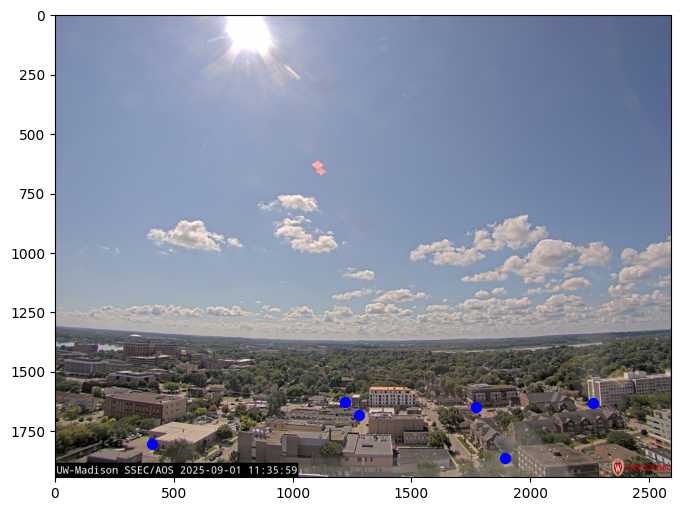

In [ ]:
image_x, image_y, cam_distance = gps_to_camxy_vasha_fixed(
            poi_gps[:, 0],  # lats
            poi_gps[:, 1],  # lons
            poi_gps[:, 2],  # alts
            cam_k=k_matrix,
            cam_r=r_matrix,
            cam_t=t_vector,
            cam_ecef=cam_ecef_coords,
            camera_gps=(origin_lat, origin_lon, origin_alt),
            distortion=dist_coeffs
        )

# plot the reprojected points on the default image
plt.figure(figsize=(8, 6))
plt.imshow(default_img)
plt.scatter(image_x, image_y, c='blue', s=50, marker='o', label='Reprojected POIs')

In [ ]:
import math as Math
def get_moon_direction_from_camera(timestamp, camera_gps):
    """
    Get moon as unit direction vector from camera location
    
    Returns:
        Unit vector [x, y, z] pointing toward moon
    """
    # Get observer location
    location = EarthLocation(lat=camera_gps[0]*u.deg, 
                           lon=camera_gps[1]*u.deg, 
                           height=camera_gps[2]*u.m)
    
    # Get moon in local Alt-Az coordinates
    moon = get_body('moon', timestamp)
    altaz_frame = AltAz(obstime=timestamp, location=location)
    moon_altaz = moon.transform_to(altaz_frame)
    
    azimuth = moon_altaz.az.radian
    elevation = moon_altaz.alt.radian
    
    # Convert to unit direction vector (local ENU coordinates)
    x = np.cos(elevation) * np.sin(azimuth)  # East
    y = np.cos(elevation) * np.cos(azimuth)  # North  
    z = np.sin(elevation)                    # Up
    
    return np.array([x, y, z])
def move_along_direction_enu(start_pos, direction_vector, distance_m):
    """
    Move along a direction vector from GPS coordinates using ENU system.
    
    Args:
        start_pos: [lat, lon] or [lat, lon, alt] in degrees and meters
        direction_vector: [east, north, up] components (can be numpy array)
        distance_m: Distance to move in meters
    
    Returns:
        [new_lat, new_lon] or [new_lat, new_lon, new_alt] depending on input
    """
    # Extract starting position
    start_lat = start_pos[0]
    start_lon = start_pos[1] 
    start_alt = start_pos[2] if len(start_pos) > 2 else 0.0
    
    # Extract direction components (ENU format)
    east = float(direction_vector[0])
    north = float(direction_vector[1])
    up = float(direction_vector[2]) if len(direction_vector) > 2 else 0.0
    
    # Since your function returns a unit vector, magnitude should be 1
    # But let's verify and normalize just in case
    magnitude = Math.sqrt(east*east + north*north + up*up)
    if magnitude == 0:
        return list(start_pos)
    
    # Scale to desired distance in ENU coordinates
    east_m = (east / magnitude) * distance_m
    north_m = (north / magnitude) * distance_m
    up_m = (up / magnitude) * distance_m
    
    # Convert ENU displacement to new GPS coordinates
    new_lat, new_lon, new_alt = pm.enu2geodetic(
        east_m, north_m, up_m,
        start_lat, start_lon, start_alt
    )
    
    # Return in same format as input
    if len(start_pos) == 2:
        return [new_lat, new_lon]
    else:
        return [new_lat, new_lon, new_alt]

def solve_pose_with_moon_directions(moon_timestamps, moon_pixels, camera_gps, 
                                  camera_matrix):
    """
    Solve camera pose using moon as direction vectors at arbitrary scale
    
    Args:
        scale_factor: Distance to place moon directions (meters)
    """
    moon_3d_points = []
    
    for timestamp in moon_timestamps:
        moon_direction = get_moon_direction_from_camera(timestamp, camera_gps)
        # Scale the unit vector to reasonable distance
        moon_scaled = moon_direction
        moon_3d_points.append(moon_scaled)
    
    moon_3d_points = np.array(moon_3d_points, dtype=np.float32)
    moon_2d_points = np.array(moon_pixels, dtype=np.float32)
    
    success, rvec, tvec = cv2.solvePnP(
        moon_3d_points * 100,  # Scale to 100 meters
        moon_2d_points,
        camera_matrix,
        None,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    
    return rvec, tvec

In [ ]:
rvec, tvec = solve_pose_with_moon_directions(image_times, moon_pixels,  
                                  camera_gps=(origin_lat, origin_lon, origin_alt), 
                                  camera_matrix=initial_k)

estimate_camera_params(origin_gps=(origin_lat, origin_lon, origin_alt),
                       poi_ecef=all_poi_ecef,
                       poi_xy=all_poi_xy,
                       frame_size=frame_size,
                       intrinsics_estimate=initial_k,
                       distortion_estimate=None, rvecs=rvec, tvecs=tvec)
# pretty print r_matrix and t_vector k and distortion
print("Camera Intrinsics (K matrix):\n", k_matrix)
print("Distortion Coefficients:\n", dist_coeffs.ravel())
print("Rotation Matrix (R):\n", r_matrix)
print("Translation Vector (T):\n", t_vector.ravel())    

Initial intrinsics:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion:
 [0. 0. 0. 0. 0.]
Camera Intrinsics (K matrix):
 [[1.24619214e+03 0.00000000e+00 1.29600000e+03]
 [0.00000000e+00 1.24619214e+03 9.72000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [-0.1225489  0.         0.         0.         0.       ]
Rotation Matrix (R):
 [[-0.99900784 -0.04382149 -0.00793852]
 [ 0.02111117 -0.30902946 -0.95081813]
 [ 0.03921303 -0.95004235  0.30964798]]
Translation Vector (T):
 [ 7.67350468 -0.19933308 -9.19120642]


Initial intrinsics:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion:
 [0. 0. 0. 0. 0.]


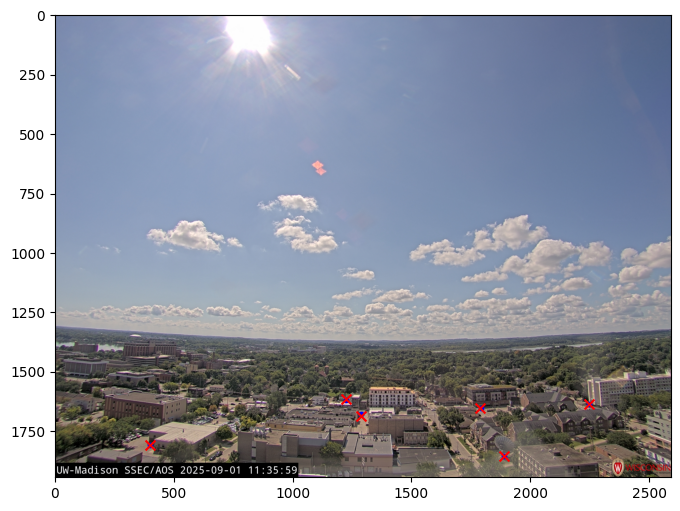

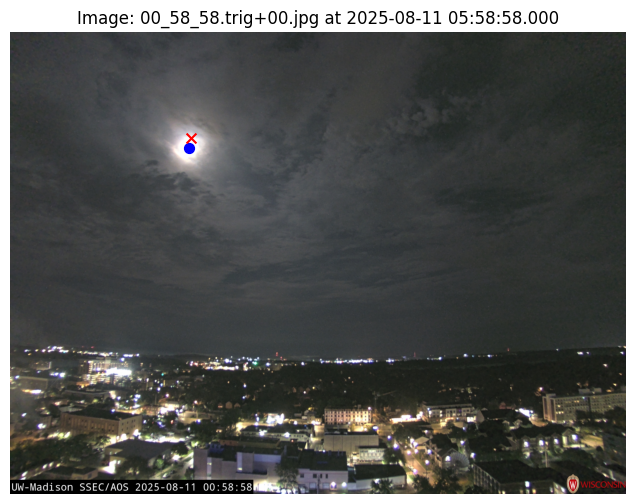

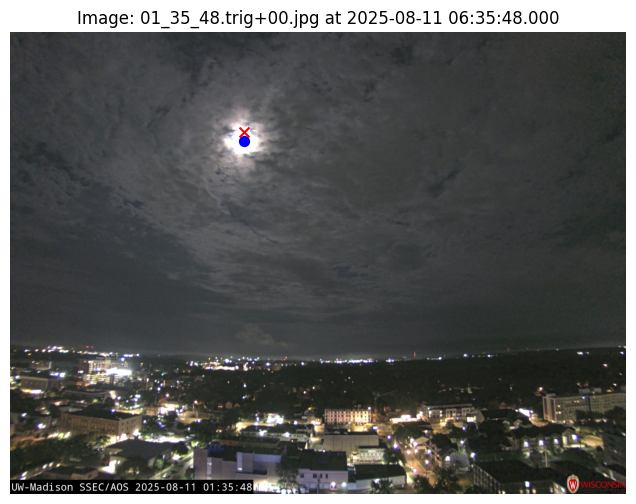

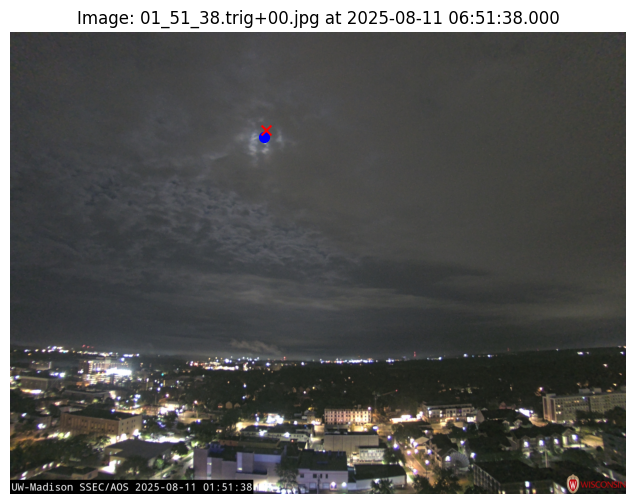

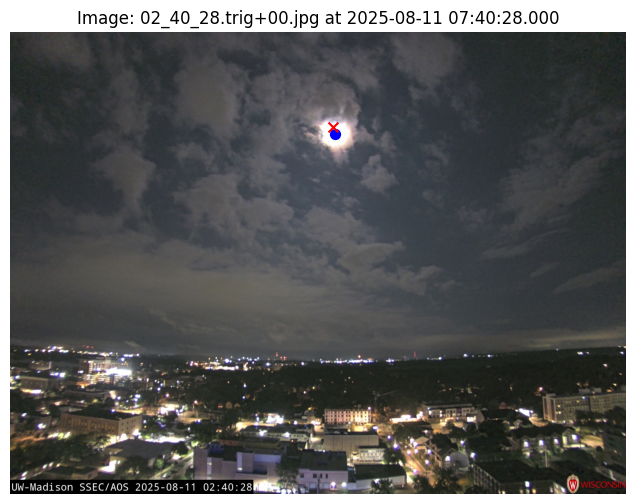

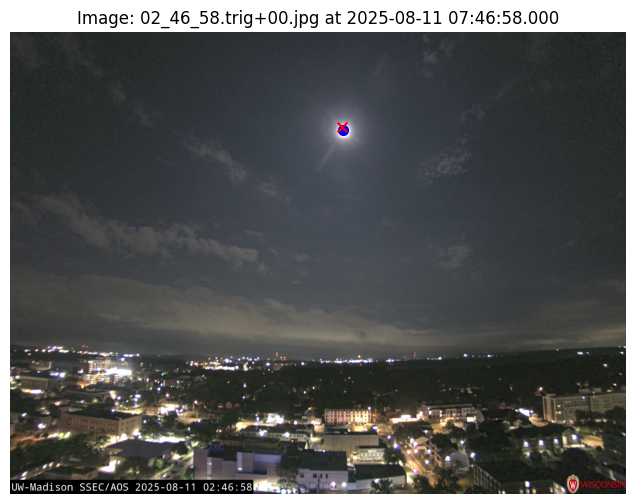

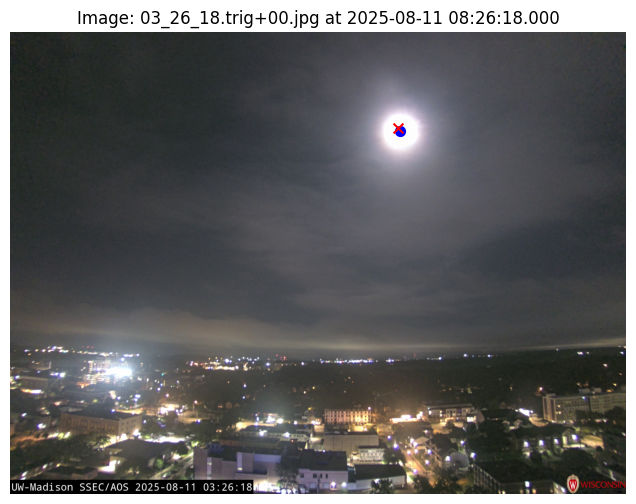

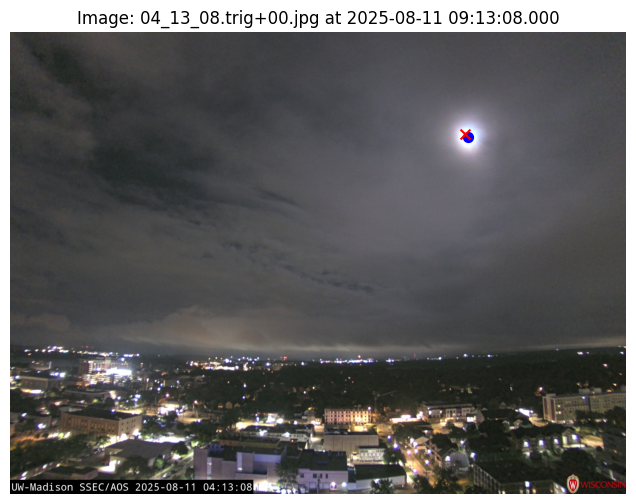

In [ ]:
def plotpoints():
    k_matrix, dist_coeffs, r_matrix, t_vector, cam_ecef_coords = estimate_camera_params(origin_gps=(origin_lat, origin_lon, origin_alt),
                       poi_ecef=all_poi_ecef,
                       poi_xy=all_poi_xy,
                       frame_size=frame_size,
                       intrinsics_estimate=initial_k,
                       distortion_estimate=None, rvecs=rvec, tvecs=tvec)
    image_x, image_y, cam_distance = gps_to_camxy_vasha_fixed(
                poi_gps[:, 0],  # lats
                poi_gps[:, 1],  # lons
                poi_gps[:, 2],  # alts
                cam_k=k_matrix,
                cam_r=r_matrix,
                cam_t=t_vector,
                cam_ecef=cam_ecef_coords,
                camera_gps=(origin_lat, origin_lon, origin_alt),
                distortion=dist_coeffs
            )

    # plot the reprojected points on the default image
    plt.figure(figsize=(8, 6))
    plt.imshow(default_img)
    for i, (x, y) in enumerate(poi_xy):
        # draw as cross
        plt.scatter(x, y, c='blue', s=10, marker='o')
    plt.scatter(image_x, image_y, c='red', s=50, marker='x', label='Reprojected POIs')
    # draw moon on each image
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        # Fix: .reverse() returns None, so assign reversed list to moon_pixels
        # covert moon location to image pixels using gps_to_camxy_vasha_fixed
        moon_dir = get_moon_direction_from_camera(image_times[i], (origin_lat, origin_lon, origin_alt))
        moon_gps = move_along_direction_enu((origin_lat, origin_lon, origin_alt), moon_dir, 10000)
        moon_image_x, moon_image_y, _ = gps_to_camxy_vasha_fixed(
            moon_gps[0:1],  # lats
            moon_gps[1:2],  # lons
            [moon_gps[2]],  # alts
            cam_k=k_matrix,
            cam_r=r_matrix,
            cam_t=t_vector,
            cam_ecef=cam_ecef_coords,
            camera_gps=(origin_lat, origin_lon, origin_alt),
            distortion=dist_coeffs
        )
        plt.scatter(moon_pixels[i][0], moon_pixels[i][1], c='blue', s=50, marker='o')
        plt.scatter(moon_image_x, moon_image_y, c='red', s=50, marker='x', label='Reprojected POIs')
        plt.title(f"Image: {img_file} at {image_times[i].iso}")
        plt.axis('off')
        plt.show()
plotpoints()